In [1]:
# !pip uninstall virny -y

In [2]:
# Install using an HTTP link
# !pip install git+https://github.com/DataResponsibly/Virny.git@feature/add_datasets_for_benchmark

# Install using an SSH link
# !pip install git+ssh://git@github.com/DataResponsibly/Virny.git@feature/add_datasets_for_benchmark

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
import warnings
warnings.filterwarnings('ignore')
os.environ["PYTHONWARNINGS"] = "ignore"

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

from virny.datasets import LawSchoolDataset
from virny.utils.model_tuning_utils import tune_ML_models
from virny.preprocessing.basic_preprocessing import preprocess_dataset
from virny.utils.data_viz_utils import create_dataset_stats_bar_chart
from virny.utils.custom_initializers import create_models_config_from_tuned_params_df

from pprint import pprint
from datetime import datetime, timezone
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from EDA_utils import get_correlation_with_target, get_correlation_matrix, get_features_by_target_correlation_threshold

## Load dataset

In [4]:
DATASET_SPLIT_SEED = 100
MODELS_TUNING_SEED = 100
TEST_SET_FRACTION = 0.2
DATASET_NAME = 'Law_School'

sensitive_attributes_dct = {'male': '0', 'race': 'Non-White', 'male & race': None}
sensitive_attributes = [attr for attr in sensitive_attributes_dct.keys() if '&' not in attr]

In [5]:
data_loader = LawSchoolDataset()
data_loader.full_df.head()

,decile1b,decile3,lsat,ugpa,zfygpa,zgpa,fulltime,fam_inc,male,tier,race,pass_bar
0,10.0,10.0,44.0,3.5,1.33,1.88,1,5,0,4,White,1
1,5.0,4.0,29.0,3.5,-0.11,-0.57,1,4,0,2,White,1
2,8.0,7.0,37.0,3.4,0.63,0.37,1,3,1,4,White,1
3,8.0,7.0,43.0,3.3,0.67,0.34,1,4,0,4,White,1
4,3.0,2.0,41.0,3.3,-0.67,-1.30,1,4,0,5,White,1


In [7]:
data_loader.full_df['tier'].unique()

array(['4', '2', '5', '3', '1', '6'], dtype=object)

In [18]:
data_loader.target

'pass_bar'

In [19]:
data_loader.full_df.shape

(20798, 12)

In [20]:
data_loader.full_df.isnull().sum()

decile1b    0
decile3     0
lsat        0
ugpa        0
zfygpa      0
zgpa        0
fulltime    0
fam_inc     0
male        0
tier        0
race        0
pass_bar    0
dtype: int64

## Check proportions and base rates

In [21]:
create_dataset_stats_bar_chart(data_loader.X_data, data_loader.y_data, sensitive_attributes_dct)

alt.FacetChart(...)

### Data Profiling

In [12]:
for col in data_loader.categorical_columns:
    print(f'{col}: {len(data_loader.full_df[col].unique())}')

fulltime: 2
fam_inc: 5
male: 2
tier: 6
race: 2


In [13]:
column_transformer = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(categories='auto', handle_unknown='ignore', sparse=False), data_loader.categorical_columns)
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
)
column_transformer = column_transformer.set_output(transform="pandas")  # Set transformer output to a pandas df

In [14]:
full_processed_df = column_transformer.fit_transform(data_loader.full_df)
list(full_processed_df.columns)

['fulltime_1.0',
 'fulltime_2.0',
 'fam_inc_1.0',
 'fam_inc_2.0',
 'fam_inc_3.0',
 'fam_inc_4.0',
 'fam_inc_5.0',
 'male_0.0',
 'male_1.0',
 'tier_1.0',
 'tier_2.0',
 'tier_3.0',
 'tier_4.0',
 'tier_5.0',
 'tier_6.0',
 'race_Non-White',
 'race_White',
 'decile1b',
 'decile3',
 'lsat',
 'ugpa',
 'zfygpa',
 'zgpa',
 'pass_bar']

### Correlation of sensitive attributes with the target

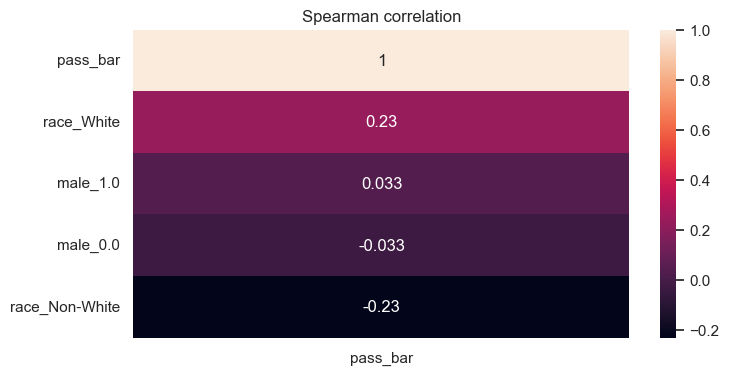

In [15]:
get_correlation_with_target(df=full_processed_df,
                            target_name=data_loader.target,
                            feature_names=[col for col in full_processed_df.columns \
                                           if col != data_loader.target \
                                           and (col.startswith(sensitive_attributes[0]) or col.startswith(sensitive_attributes[1]))
                                           ],
                            heatmap_size=(4, 8))

### Correlation of selected attributes with the target

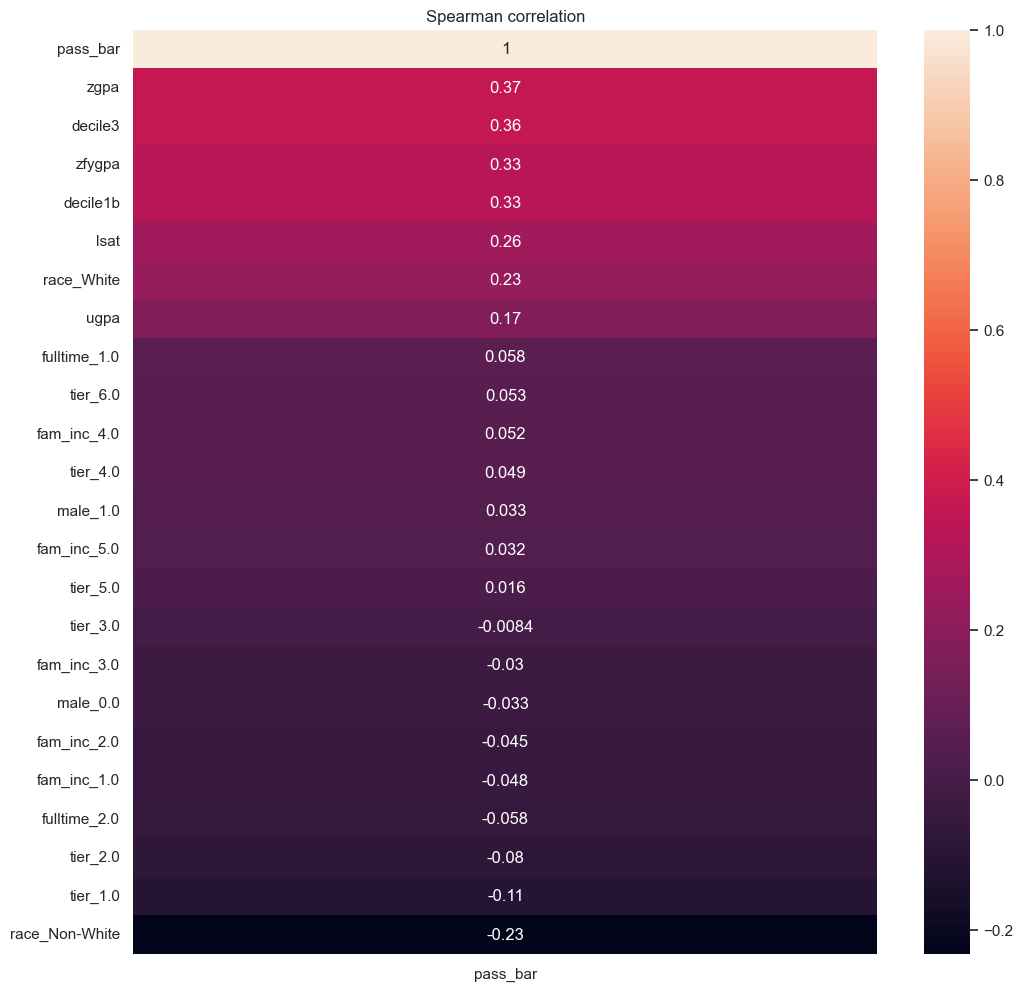

In [27]:
filtered_feature_names = [col for col in full_processed_df.columns if col != data_loader.target]
get_correlation_with_target(df=full_processed_df,
                            target_name=data_loader.target,
                            feature_names=filtered_feature_names,
                            heatmap_size=(12, 12))

### Correlation matrix for features which have high correlation with the target

In [17]:
high_correlated_features = get_features_by_target_correlation_threshold(
    df=full_processed_df[filtered_feature_names + [data_loader.target]],
    target=data_loader.target,
    threshold=0.1
)
high_correlated_features

['tier_1.0',
 'race_Non-White',
 'race_White',
 'decile1b',
 'decile3',
 'lsat',
 'ugpa',
 'zfygpa',
 'zgpa']

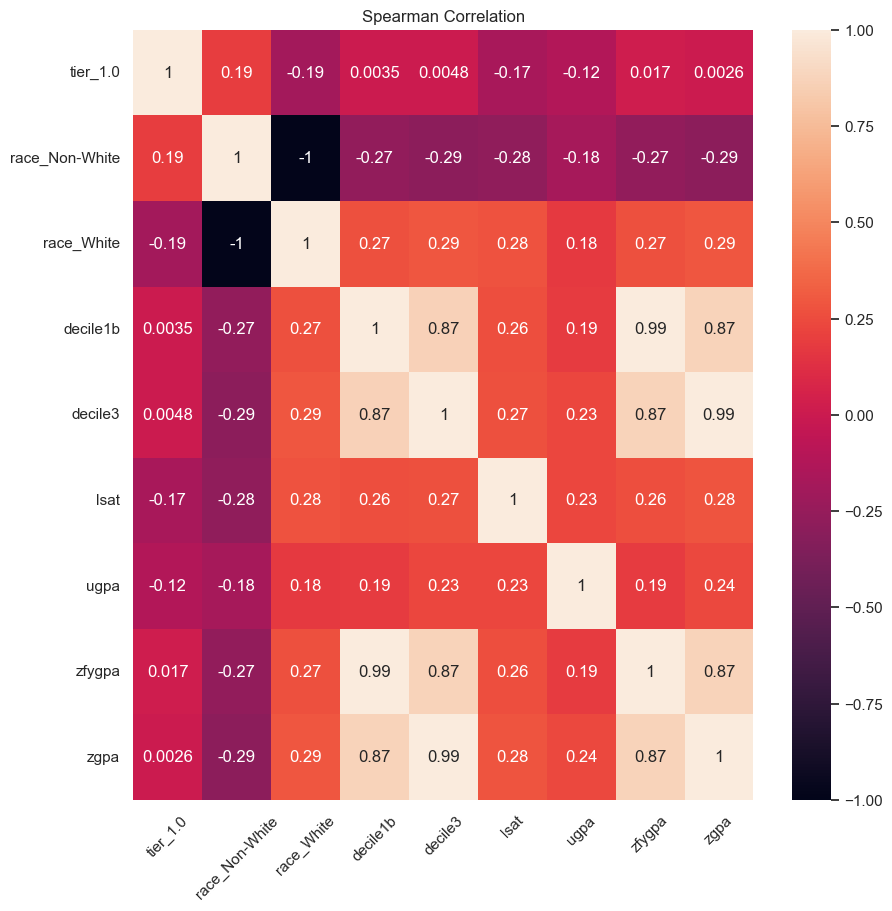

In [18]:
get_correlation_matrix(df=full_processed_df,
                       feature_names=high_correlated_features,
                       heatmap_size=(10, 10))

## Data preparation

In [19]:
column_transformer = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(categories='auto', handle_unknown='ignore', sparse=False), data_loader.categorical_columns),
        ('num', StandardScaler(), data_loader.numerical_columns),
    ],
    verbose_feature_names_out=False
)

In [20]:
base_flow_dataset = preprocess_dataset(data_loader=data_loader,
                                       column_transformer=column_transformer,
                                       sensitive_attributes_dct=sensitive_attributes_dct,
                                       test_set_fraction=TEST_SET_FRACTION,
                                       dataset_split_seed=DATASET_SPLIT_SEED)

## Tune RandomForest

In [21]:
models_params_for_tuning = {
    'RandomForestClassifier': {
        'model': RandomForestClassifier(random_state=MODELS_TUNING_SEED),
        'params': {
            'n_estimators': [100, 200, 500],
            'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'bootstrap': [True, False]
        }
    },
}

In [22]:
# tuned_params_df, models_config = tune_ML_models(models_params_for_tuning, base_flow_dataset, DATASET_NAME, n_folds=3)
# tuned_params_df

In [23]:
# now = datetime.now(timezone.utc)
# date_time_str = now.strftime("%Y%m%d__%H%M%S")
# tuned_df_path = os.path.join(os.getcwd(), 'models_tuning', f'tuning_results_{DATASET_NAME}.csv')
# tuned_params_df.to_csv(tuned_df_path, sep=",", columns=tuned_params_df.columns, float_format="%.4f", index=False)

## Analyze Feature Importance With Scikit-Learn

In [24]:
tuned_df_path = os.path.join(os.getcwd(), 'models_tuning', f'tuning_results_{DATASET_NAME}.csv')
models_config = create_models_config_from_tuned_params_df(models_params_for_tuning, tuned_df_path)
pprint(models_config)

{'RandomForestClassifier': RandomForestClassifier(max_depth=20, min_samples_split=5, random_state=100)}


In [25]:
rf = models_config['RandomForestClassifier']
rf = rf.fit(base_flow_dataset.X_train_val, base_flow_dataset.y_train_val)

Text(0.5, 1.0, 'Global Feature Importance - Built-in Method')

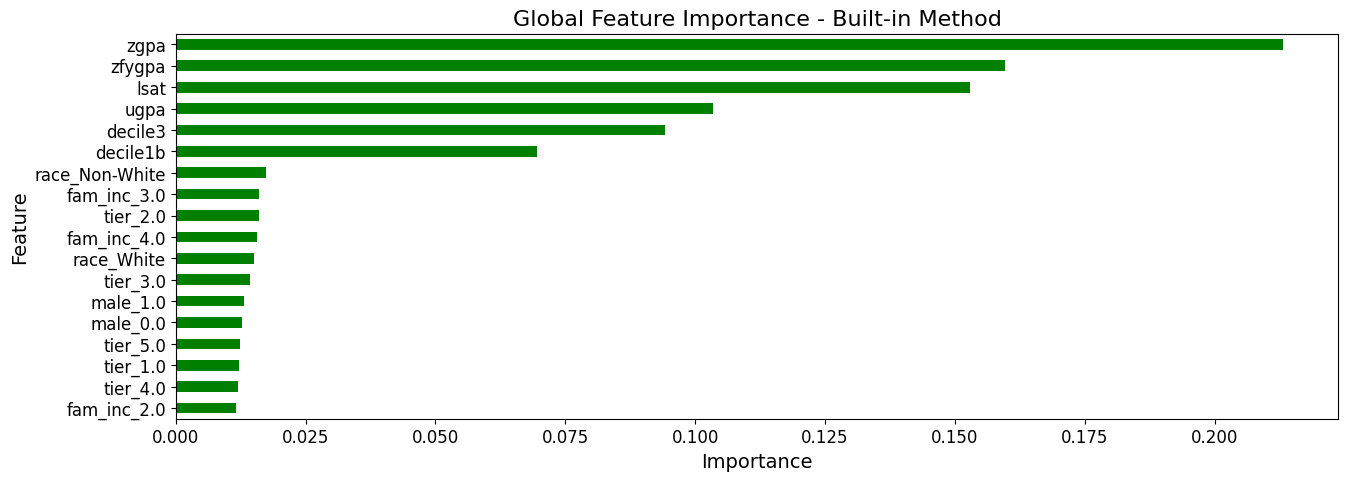

In [26]:
global_importances = pd.Series(rf.feature_importances_, index=base_flow_dataset.X_train_val.columns)
global_importances = global_importances[global_importances > 0.01]
global_importances.sort_values(ascending=True, inplace=True)
global_importances.plot.barh(color='green')

plt.xlabel("Importance", fontsize=14)
plt.ylabel("Feature", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title("Global Feature Importance - Built-in Method", fontsize=16)